We import `IBMQBackend` and load our IBM token from a .env file

In [1]:
from pytket.extensions.qiskit import IBMQBackend

from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
ibm_token = os.getenv('IBM_QUANTUM_API_TOKEN')

for logging into the runtime service

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True)

Then we can check the QPUs (*Quantum Processing Units*) available to us and select one. In this case we'll select `ibm_brisbane`

In [4]:
backendinfo_list = IBMQBackend.available_devices()
print([backend.device_name for backend in backendinfo_list])

['ibm_brisbane', 'ibm_kyiv', 'ibm_sherbrooke']


In [5]:
backend = IBMQBackend("ibm_brisbane")

We then take a very small size puzzle

In [ ]:
from sudoku_nisq.q_sudoku import Sudoku

sudoku = Sudoku(grid_size=2,num_missing_cells=3)

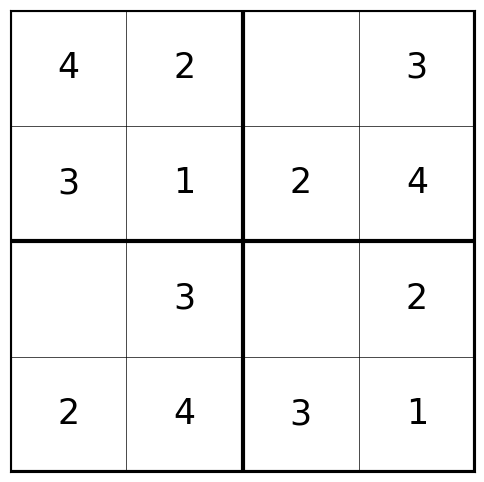

In [7]:
sudoku.plot()

We initialize the quantum solver object and find resources for the rough circuit:

In [8]:
sudoku.init_quantum(simple=False,pattern=True)

sudoku.quantum.find_resources()

# Number of qubits || Number of MCX gates || Total number of gates

(15, 47, 60)

Then we initialize and draw the circuit 

In [9]:
circuit = sudoku.quantum.get_circuit()

In [10]:
sudoku.quantum.draw_circuit()

We then compile for the selected backend.

(We use the `FlattenRegisters` function to fix the naming of our original circuit's registers and ensure compatibility with the backend's compiler)

In [11]:
from pytket.passes import FlattenRegisters

flatten = FlattenRegisters()
flatten.apply(circuit)

compiled_circuit = backend.get_compiled_circuit(circuit)

Notice that the resources are much higher than the uncompiled circuit's estimate. This is partially due to the architecture of the QPU, as we are building a highly entangled state but not every qubit can readily connect to every other qubit so intermediate gates and auxiliary qubits are required:

In [12]:
compiled_circuit.n_qubits

17

In [14]:
compiled_circuit.depth()

4114

In [18]:
compiled_circuit.n_gates

10414

We process the circuit and plot the results:

In [15]:
handle = backend.process_circuit(compiled_circuit,n_shots = 1024)

(one can keep the `str(handle)` for later retrieval of the data)

In [16]:
# assert backend.persistent_handles
print(str(handle))
counts = backend.get_result(handle).get_counts()
print(counts)

('cw1pwna79ws0008z3mk0', 0, 2, 'null')
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is RUNNING
Job status is R

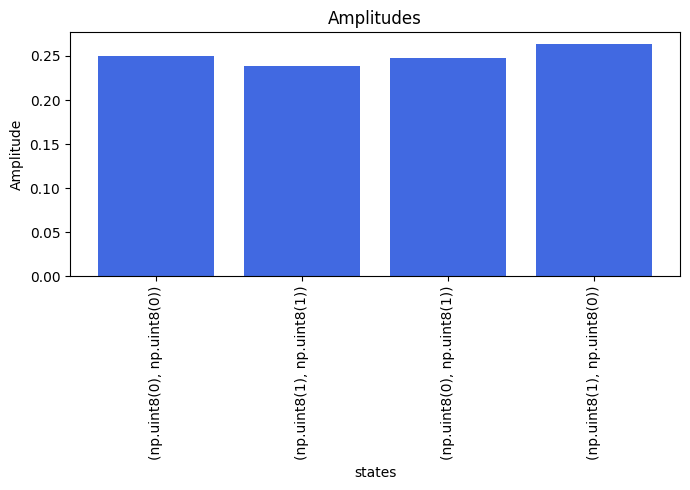

In [17]:
sudoku.quantum.counts_plot(counts)

Notice that the results show a fairly uniform distribution of all possible results. This case corresponds to a failure due to the high resource requirements and the relatively low power of the QPU.

Let me elaborate:

From IBM's [website about their QPUs](https://quantum.ibm.com/services/resources) we can find `ibm_brisbane`'s details, in particular, its coherence times and circuit layer operations per second (CLOPS):

*Median T1 (Relaxation Time)*: $220.84 μs = 0.00022084 s$

- This is the average time a qubit remains in an excited state before decaying to its ground state.

*Median T2 (Dephasing Time)*: $134.91 μs = 0.00013491 s$

- This is the average time over which a qubit can maintain its coherence, or superposition, before losing its phase information due to environmental noise and interactions.

*CLOPS*: $30,000$

- This means the processor can execute 30,000 circuit layers per second.

In our example we obtained a circuit depth of the compiled circuit of roughly $4000$, so a total execution time at $30,000$ CLOPS corresponds to

$$
\text{Total Execution Time} = \frac{\text{Circuit Depth}}{\text{CLOPS}} = \frac{4,000}{30,000 \text{layers}/\text{s}} \approx 0.13 \text{s}
$$

Which is a few orders of magnitude greater than the coherence times. So our quantum state was no longer quantum way before the algorithm finished.